<a href="https://colab.research.google.com/github/akispan/test-repo/blob/main/police.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
import json

with open('/content/drive/My Drive/data_for_colab/police/data.json') as f:
    data = json.load(f)

In [ ]:
original_size = 0
delete_size = 0
for item in data:
  for i in reversed(item[1]):
    original_size += 1
    if i['text'] == 'Δείτε τον πίνακα εδώ':
      item[1].remove(i)
      delete_size += 1
print('Total   size :',original_size)
print('Anused  size :',delete_size)
print('Process size :',original_size - delete_size)

Total   size : 1789
Anused  size : 46
Process size : 1743


In [ ]:
for month in data:

    for report in month[1]:

        if 'ΔΕΛΤΙΟ ΤΥΠΟΥ' in report['text']:
            report['text'] = report['text'].split('ΔΕΛΤΙΟ ΤΥΠΟΥ')[1].strip()
        elif 'ΑΝΑΚΟΙΝΩΣΗ' in report['text']:
            report['text'] = report['text'].split('ΑΝΑΚΟΙΝΩΣΗ')[1].strip()

In [ ]:
!pip install spacy
!pip install spacy download en_core_web_sm

import pandas as pd
from pprint import pprint
from spacy.lang.el.examples import sentences 
from spacy import displacy
from spacy.matcher import Matcher
import spacy
import spacy.cli
from collections import defaultdict
%matplotlib inline
spacy.cli.download("el_core_news_sm")

✔ Download and installation successful
You can now load the model via spacy.load('el_core_news_sm')


In [ ]:
'''
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def has_number(s):
  for i in s.split():
      if is_number(i):
          return True
  return False 

def get_capitalized(item):

    letters = {'Ά':'Α','Έ':'Ε','Ή':'Η','Ί':'Ι','Ό':'Ο','Ύ':'Υ','Ώ':'Ω'}

    item = item.upper()
    for i in item:
        if i in letters.keys():
            item = item.replace(i, letters[i])
    return item


text = data[1][1][0]['text']

nlp = spacy.load("el_core_news_sm")
doc = nlp(text)
displacy.render(doc, style="ent", jupyter=True)

print(40 * '-')

for ent in doc.ents:
    print(ent.text, ent.label_)

tokens = defaultdict(int)
for ent in doc.ents:
    entity = get_capitalized(ent.text)
    tokens[(entity,ent.label_)] = 1
'''

In [ ]:
import json

with open('/content/drive/My Drive/data_for_colab/police/tokens_keep.json') as f:
    tokens_keep = json.load(f)
with open('/content/drive/My Drive/data_for_colab/police/name_correction.json') as f:
    name_correction = json.load(f)

In [ ]:
from tqdm import tqdm

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def has_number(s):
  for i in s:
      if is_number(i):
          return True
  return False 

def get_capitalized(item):
    letters = {'Ά':'Α','Έ':'Ε','Ή':'Η','Ί':'Ι','Ό':'Ο','Ύ':'Υ','Ώ':'Ω'}
    item = item.upper()
    for i in item:
        if i in letters.keys():
            item = item.replace(i, letters[i])
    return item

def get_tokens_from_text(mytext):
    tokens = defaultdict(int)
    nlp = spacy.load("el_core_news_sm")
    doc = nlp(mytext)
    for ent in doc.ents:
        if ent.label_ == 'GPE': 
            entity = get_capitalized(ent.text)
            tokens[entity] = 1
    return tokens


print('--- Find Tokens extraction Started ---')

tokens_dict = defaultdict(int)

pbar = tqdm(data, total=len(data))
for month in pbar:

    tokens_per_month = defaultdict(int)
    # print('month')
    for report in month[1]:

        text = report['text']
        tokens = get_tokens_from_text(text)
        # print(tokens)
        for k in tokens:
            if k in tokens_keep:
                if k in name_correction:
                    tokens_per_month[name_correction[k]] += 1  
                else:
                    tokens_per_month[k] += 1 
    tokens_dict.update({month[0]: tokens_per_month})
    # pprint(tokens_dict)
    # print(40 * '-')

  0%|          | 0/28 [00:00<?, ?it/s]

--- Find Tokens extraction Started ---


100%|██████████| 28/28 [10:57<00:00, 23.48s/it]


In [ ]:
with open('/content/drive/My Drive/data_for_colab/police/tokens_dict.json', 'w') as json_file:
    json.dump(tokens_dict, json_file)

In [ ]:
tokens = defaultdict(int)

for res in tokens_dict.values():
    # print(res)
    for k, val in res.items():
        tokens[k] += val

In [ ]:
with open('/content/drive/My Drive/data_for_colab/police/tokens.json', 'w') as json_file:
    json.dump(tokens, json_file)

In [ ]:
!pip install geopandas
!pip install geopy

     |████████████████████████████████| 1.0MB 16.1MB/s 
     |████████████████████████████████| 15.3MB 276kB/s 
     |████████████████████████████████| 6.5MB 36.4MB/s 


In [ ]:
import geopandas
import geopy
from geopy import Nominatim

locator = Nominatim(user_agent='myGeocoder')

location = locator.geocode('ΝΙΚΑΙΑ ΑΤΤΙΚΗΣ')
  
# latitude.append(location.latitude)
# longitude.append(location.longitude)
print('Latitude, Longitude : {} {}'.format(location.latitude, location.longitude))

Latitude, Longitude : 37.9657507 23.6473298


In [ ]:
import geopandas
import geopy
from geopy import Nominatim

locator = Nominatim(user_agent='myGeocoder')

latitude  = []
longitude = []
times     = []

for loc in sorted(tokens.keys()):

  # print(loc)
  location = locator.geocode(loc)
  
  try:
    latitude.append(location.latitude)
    longitude.append(location.longitude)
    times.append(tokens[loc])
    # print('Latitude, Longitude : {} {}'.format(location.latitude, location.longitude))
  except:
    print(loc)
  #   print('wrong name')
  # print(40 * '-')


In [ ]:
with open('/content/drive/My Drive/data_for_colab/police/latitude.json', 'w') as json_file:
    json.dump(latitude, json_file)
with open('/content/drive/My Drive/data_for_colab/police/longitude.json', 'w') as json_file:
    json.dump(longitude, json_file)
with open('/content/drive/My Drive/data_for_colab/police/times.json', 'w') as json_file:
    json.dump(times, json_file)

In [ ]:
df = pd.DataFrame(zip(latitude, longitude, times), columns = ['Latitude', 'Longitude', 'Magnitude'])

import pandas as pd
import plotly.express as px

fig = px.density_mapbox(df, lat='Latitude', lon='Longitude', z='Magnitude',
                        color_continuous_midpoint = 0,
                        radius=30,
                        center=dict(lat=37.97728639084097, lon=23.726664468538466), 
                        zoom=6,
                        width=1000,
                        height=1000,
                        mapbox_style="stamen-terrain")

fig.update_layout(margin=dict(b=0, t=0, l=0, r=0))
fig.show()

In [ ]:
import json

with open('/content/drive/My Drive/data_for_colab/police/data.json') as f:
    data = json.load(f)
with open('/content/drive/My Drive/data_for_colab/police/data.json') as f:
    data = json.load(f)
with open('/content/drive/My Drive/data_for_colab/police/data.json') as f:
    data = json.load(f)
with open('/content/drive/My Drive/data_for_colab/police/data.json') as f:
    data = json.load(f)

In [ ]:
years = ['2019','2020','2021']
months = ['Ιανουάριος ','Φεβρουάριος ','Μάρτιος ','Απρίλιος ','Μάιος ','Ιούνιος ','Ιούλιος ', 'Αύγουστος ','Σεπτέμβριος ','Οκτώβριος ','Νοέμβριος ','Δεκέμβριος ']

dates = []          
for year in years:
  
  if year == '2021':
    for month in months[:4]:
      dates.append(month + year)
  else:
    for month in months:
      dates.append(month + year)
dates

['Ιανουάριος 2019',
 'Φεβρουάριος 2019',
 'Μάρτιος 2019',
 'Απρίλιος 2019',
 'Μάιος 2019',
 'Ιούνιος 2019',
 'Ιούλιος 2019',
 'Αύγουστος 2019',
 'Σεπτέμβριος 2019',
 'Οκτώβριος 2019',
 'Νοέμβριος 2019',
 'Δεκέμβριος 2019',
 'Ιανουάριος 2020',
 'Φεβρουάριος 2020',
 'Μάρτιος 2020',
 'Απρίλιος 2020',
 'Μάιος 2020',
 'Ιούνιος 2020',
 'Ιούλιος 2020',
 'Αύγουστος 2020',
 'Σεπτέμβριος 2020',
 'Οκτώβριος 2020',
 'Νοέμβριος 2020',
 'Δεκέμβριος 2020',
 'Ιανουάριος 2021',
 'Φεβρουάριος 2021',
 'Μάρτιος 2021',
 'Απρίλιος 2021']

In [ ]:
areas = list(sorted(tokens))

graph_data = {}

for area in areas:

    month_array = [0]*28

    for i, date in zip(range(28), dates):
        if area in tokens_dict[date]:
            month_array[i] = tokens_dict[date][area]

    graph_data.update({area:month_array})

In [ ]:
tokens_dict['Απρίλιος 2020']

defaultdict(int,
            {'Argiroupoli': 1,
             'MARATHONAS': 1,
             'PL. EXARCHION': 2,
             'ΑΓΙΑ ΒΑΡΒΑΡΑ': 1,
             'ΑΓΙΑ ΠΑΡΑΣΚΕΥΗ': 1,
             'ΑΓΙΟΥ ΠΑΝΤΕΛΕΗΜΟΝΑ': 2,
             'ΑΘΗΝΑ': 7,
             'ΑΙΓΑΛΕΩ': 1,
             'ΑΣΠΡΟΠΥΡΓΟΣ': 2,
             'ΑΤΤΙΚΗ': 6,
             'ΓΛΥΦΑΔΑ': 1,
             'ΕΛΕΥΣΙΝΑ': 3,
             'ΖΩΓΡΑΦΟΥ, ΑΘΗΝΑ': 2,
             'ΚΑΛΛΙΘΕΑ': 3,
             'ΚΗΦΙΣΙΑ': 1,
             'ΚΟΡΙΝΘΟΣ': 3,
             'ΜΑΝΔΡΑΣ-ΕΙΔΥΛΛΙΑΣ': 1,
             'ΜΑΡΚΟΠΟΥΛΟ ΜΕΣΟΓΑΙΑΣ': 1,
             'ΜΑΡΟΥΣΙ': 1,
             'ΜΟΣΧΑΤΟ': 2,
             'ΝΕΑ ΣΜΥΡΝΗ': 1,
             'ΠΑΝΕΠΙΣΤΗΜΙΟΥΠΟΛΗ': 1,
             'ΠΑΤΗΣΙΑ': 1,
             'ΠΕΡΙΣΤΕΡΙ': 4,
             'ΠΕΤΡΟΥΠΟΛΗ': 1})

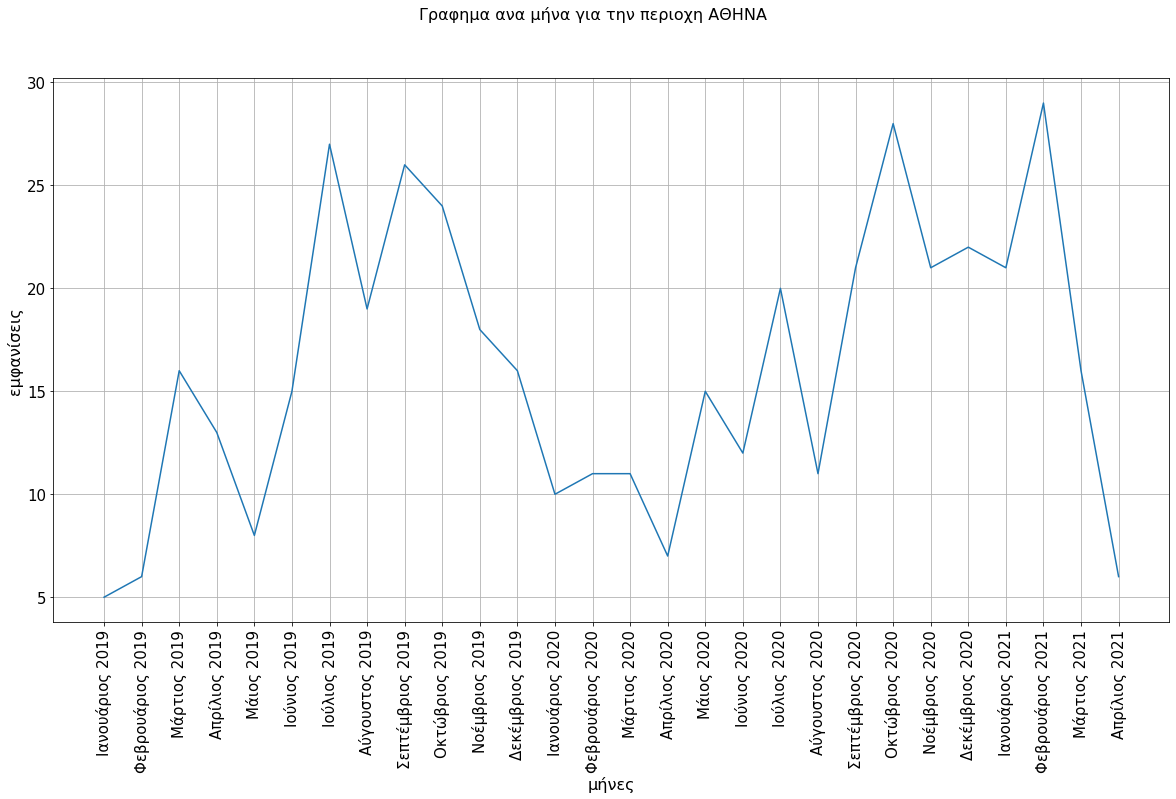

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

def plot_line(dates, graph_data, area):
  
  plt.rcParams["figure.figsize"] = (20,10)
  plt.rcParams["axes.grid"] = True
  matplotlib.rc('xtick', labelsize=15) 
  matplotlib.rc('ytick', labelsize=15) 
  fig, ax = plt.subplots()
  fig.suptitle('Γραφημα ανα μήνα για την περιοχη {}'.format(area), fontsize=16)
  plt.xlabel('μήνες', fontsize=16)
  plt.ylabel('εμφανίσεις', fontsize=16)
  ndx = [x for x in range (len(dates))]
  plt.xticks(ndx, dates, rotation='vertical')
  plt.plot( dates , graph_data)
  # plt.legend(shadow=True, fontsize="large", loc="best")
  # plt.ylim(0,1.1)   #  creates y scale from 0 to 1
  plt.show()


plot_line(dates, graph_data['ΑΘΗΝΑ'], 'ΑΘΗΝΑ')